# Period analysis for TOI 2095/TIC 235678745

[Click to open this notebook on](https://timeseries.science.stsci.edu/hub/user-redirect/git-pull?repo=https://github.com/zclaytor/smartsnn_examples&branch=main)

[<img src="TIKElogo.png" alt="TIKE logo" style="height: 75px;"/>](https://timeseries.science.stsci.edu/hub/user-redirect/git-pull?repo=https://github.com/zclaytor/smartsnn_examples&branch=main)

The goal of this notebook is to estimate the rotation period of a single star from TESS data using the CNN designed by Claytor et al. ([2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...927..219C/abstract), [2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...962...47C/abstract)). We'll use data from the TESS High Level Science Product [TESS-SPOC](https://archive.stsci.edu/hlsp/tess-spoc), which consists of FFI light curves processed with the mission pipeline.

It's important to note that the CNN used here has only been trained on Cycle 1 (Sectors 1-13) TESS data from the Southern Continuous Viewing Zone (SCVZ). The CNN may or may not usefully generalize to NCVZ light curves, or even SCVZ light curves from other cycles. This will be a useful test of its generalizability. 

## Goals

We want to go end-to-end from reading TESS data from MAST to estimating a rotation period. We'll follow these steps:
1. Search for and download light curve data using `lightkurve`,
2. Process the light curve for CNN evaluation,
3. Compute the light curve's Morlet wavelet transform, and
4. Evaluate the CNN on the wavelet transform using all available CNN models.

## Imports

We'll make use of the following packages:
- `numpy` for basic numerical and array functions,
- `pandas` to put the CNN output into a DataFrame
- `matplotlib` for plotting,
- `pytorch` for Tensor operations and reshaping the wavelet data,
- `lightkurve` for searching and downloading TESS light curves,
- [`smartsnn`](https://github.com/zclaytor/smartsnn) to load and evaluate the trained CNN, and
- [`prot`](https://github.com/zclaytor/prot) to compute wavelet transforms.

In [1]:
# Uncomment this line to install the required packages
# %pip install -r requirements.txt

In [2]:
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn.functional import adaptive_avg_pool2d
import lightkurve as lk

from smartsnn.eval import evaluate as evaluate_cnn
from prot import WaveletTransform

/opt/conda/envs/tess/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## 1. Search for and download light curve data

I'm making choices here, but feel free to experiment:
- `author="TESS-SPOC"` specifies the TESS-SPOC HLSP light curves. SPOC and QLP are also available.
- `flux_column="sap_flux"` specifies the simple aperture photometry flux, which is generally less processed than the `pdcsap_flux`. Rotational modulation is likely to be processed out in the `pdc` step.
- `quality_bitmask="hardest"` is the toughest cleaning on the data. It has been known to throw out good data, but we don't need all the data for rotation.

In [3]:
s = lk.search_lightcurve("TIC235678745", author="TESS-SPOC")
lcs = s.download_all(flux_column="sap_flux", download_dir=".", quality_bitmask="hardest")

Let's choose the Cycle 2 light curves, which are sectors 14-26. There's other data to use; just make sure you use continuous sectors spanning a baseline of ~365 days if possible.

Let's plot the light curves to see what they look like.

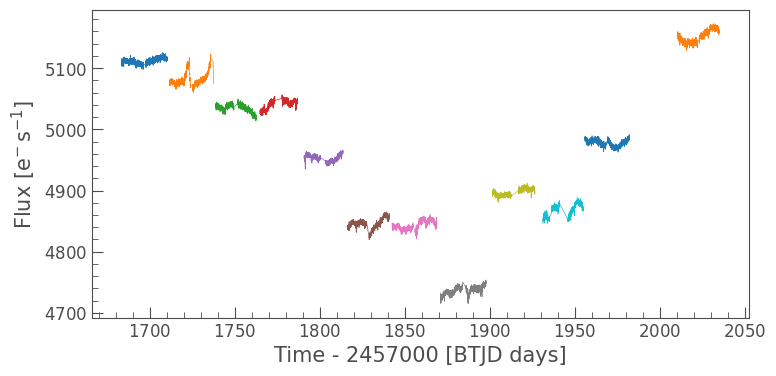

In [4]:
%matplotlib inline
ax = lcs[:12].plot()
ax.legend().remove()

There is definitely some rotational modulation present, but also these pesky sector-to-sector flux offsets. Even when we normalize the sectors and stitch the light curves together, those offsets inject artificial power into the frequency spectrum. There is work in progress to try and fit and/or remove it, but we'll ignore it for now. Since the training data also includes the offsets, ideally the CNN can learn to ignore the power injected by them.

## 2. Process the light curve

The light curve needs to look like the training data, which have the following features:
- 365-day baseline
- filled gaps
- 30-minute cadence (actually this shouldn't matter, since it gets averaged over in the wavelet step).

In [5]:
def process_lc(lc, extend_baseline=True, fill_gaps=True):
    if extend_baseline:
        time = lc.time.value
        flux = lc.flux.value
        cadence = np.median(np.diff(time))
    
        # define first cadence to be 365 days before the end, then append
        time0 = time[-1]-365 + cadence
        time = np.append(time0, time)
        flux = np.append(1, flux)
        lc = lk.LightCurve(time=time, flux=flux)

    # fill gaps if desired
    if fill_gaps:
        lc = lc.fill_gaps()
        
    return lc

lc = process_lc(lcs[:12].stitch(), extend_baseline=True, fill_gaps=True)
lc

time,flux,flux_err
,,
Time,float64,float64
1670.1348619085156,1.0,nan
1670.1556952688015,1.0002552336348531,nan
1670.1765286290874,1.0000047823138356,nan
1670.1973619893733,1.000041736943134,nan
1670.2181953496593,0.9999038878301564,nan
1670.2390287099452,0.9999610893234682,nan
1670.259862070231,1.000059653710218,nan
1670.280695430517,1.0000396238297378,nan


## 3. Compute the wavelet transform

The CNN is trained on Morlet wavelet transforms of light curves. This has the benefits of
- localizing the periodicity information
- 2D representation, which takes advantage of advances in CNN image recognition

My package `prot` uses `scipy` to compute the wavelet transform, but note that `scipy.signal.cwt` is deprecated. The `scipy` project recommends `pywavelets` as a replacement, but I haven't been able to reproduce `scipy` transforms with it. So for now I'm sticking with `scipy`.

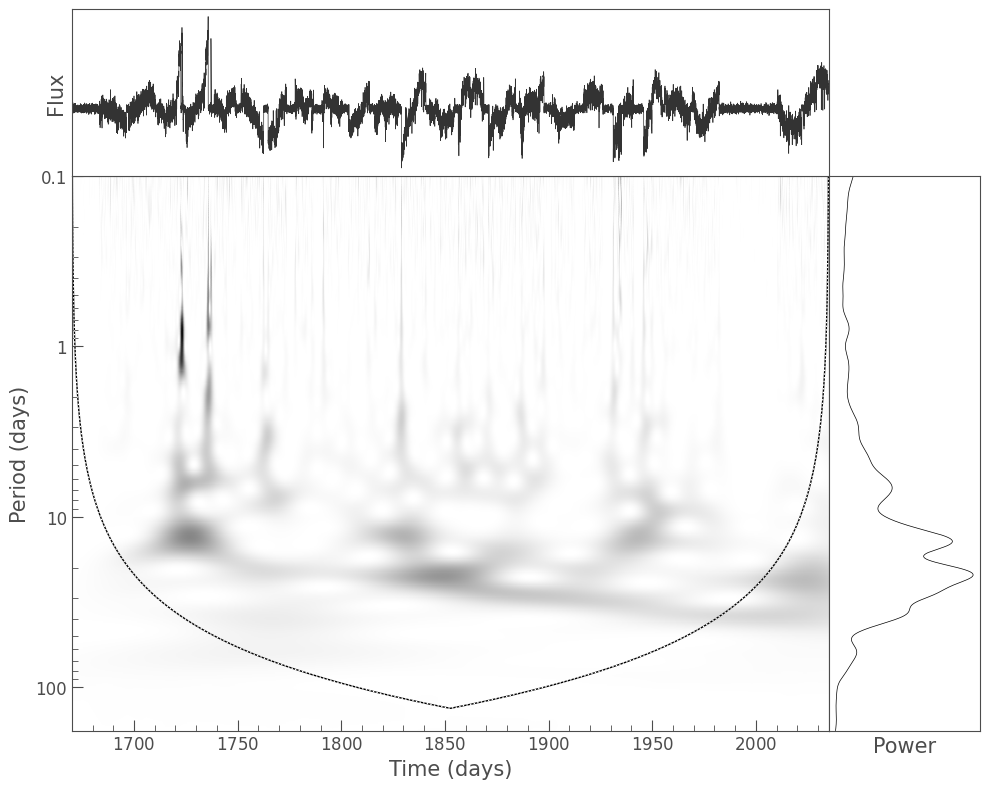

In [6]:
%matplotlib inline
wt = WaveletTransform.from_lightcurve(lc, minimum_period=0.1, maximum_period=180)
wt.plot_all(rasterized=True);

Note that we can use the wavelet transform to find the period at max power, but this is likely to pick out TESS aliases.

In [7]:
wt.period_at_max_power

22.09560184026782

Now we have to regularize the wavelet transform for CNN evaluation. The input data must have the following qualities:
- converted to `pytorch` Tensor
- resized to (1, 64, 64) shape using average pooling
- linearly scaled to have unit maximum

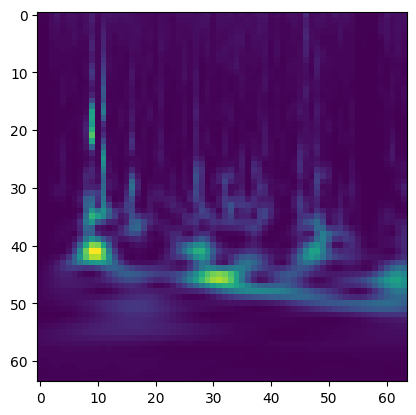

In [8]:
power = Tensor(wt.power).unsqueeze(0) # conver to tensor and add dimension in front
pooled_power = adaptive_avg_pool2d(power, (64, 64)) # resize to (1, 64, 64)
pooled_power /= pooled_power.max() # normalize to unit maximum

# plot the binned power spectrum
plt.imshow(pooled_power.numpy().squeeze())

The wavelet transform is now more grainy in resolution, but it keeps the important information (localization of power) while being extremely memory-inexpensive.

## 4. Evaluate the CNN

In my 2024 paper, I used four training sets and four CNN models of increasing complexity (so a 4x4 grid) to see how those affected period recoverability. Briefly, the four training sets spanned different ranges of periods: always from 0.1 d, but up to 30, 60, 90, and 180 d. The four CNN models varied the number of convolution kernels to see if more feature extractors improved performance. In practice, I ended up using the third CNN model (indicated by `run = 2` below), which performed best on the simulated test data. I used a combination of the predictions from the different training sets, but generally 30, 60, and 90 agreed with each other, and 180 often disagreed. This was due to a subtle difference in the training data, but I won't go into that here.

We'll evaluate all 16 CNN models and see how the predictions compare.

In [9]:
pmax = [30, 60, 90, 180]
run = [0, 1, 2, 3]

pdata = DataFrame(columns=pmax, index=run)
for r in run:
    for p in pmax:
        period, sigma = evaluate_cnn(pooled_power, f"spoc{p:03d}_{r}.pt").squeeze()
        pdata.loc[r, p] = f"{period:.02f} ± {sigma:.02f} d ({sigma/period:.03f})"

pdata

,30,60,90,180
0,20.57 ± 7.65 d (0.372),19.88 ± 8.67 d (0.436),20.62 ± 12.22 d (0.593),73.22 ± 62.02 d (0.847)
1,18.46 ± 8.79 d (0.476),21.07 ± 8.83 d (0.419),18.99 ± 8.38 d (0.441),73.46 ± 41.17 d (0.560)
2,19.57 ± 11.16 d (0.571),19.57 ± 8.16 d (0.417),17.34 ± 8.80 d (0.508),77.99 ± 80.78 d (1.036)
3,19.83 ± 8.30 d (0.418),21.12 ± 9.14 d (0.433),14.98 ± 8.30 d (0.554),50.12 ± 52.12 d (1.040)


Here we're printing period +/- sigma for each model, with (sigma/period) in parentheses. I generally use sigma/period to filter out bad predictions, and in my 2024 paper I used a value of ~0.35 as the "goodness" threshold. Note that *none* of the predictions here qualify as "good" based on that definition, so take everything after this with a grain of salt.

The 30, 60, and 90 predictions all generally agree, and the different run numbers don't really make a difference. I would assign this a period of 20 days +/- 9 or so, with the caveat that it doesn't quite satisfy my "goodness" criterion. But remember that the CNN was trained on Cycle 1 data, which has different systematics from Cycle 2, so the landscape of predictions may differ.

In future work (within the next year or so), I plan to generate new training sets for TESS Cycles 1-8 and run my machinery over all the light curves, so this can and will be refined. I encourage you to try different choices than the ones I made above and see how the output changes.

## References

- CNN design and training: [Claytor et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...927..219C/abstract)
- CNN evaluation for TESS rotation periods: [Claytor et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...962...47C/abstract)
- `smartsnn` on GitHub: https://github.com/zclaytor/smartsnn
- `prot` on GitHub: https://github.com/zclaytor/prot
- the SMARTS training dataset: https://archive.stsci.edu/hlsp/smarts
- `butterpy`, the package used to generate the SMARTS data: https://github.com/zclaytor/butterpy